In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
df = pd.read_csv('clean.csv')
df.head()

,author_ID,post,political_leaning,clean_post,nr_of_words,nr_of_characters,label
0,t2_kj8twzq5,dog (pic on my profile). Longer hair but other...,center,dog pic profile longer hair spot unfortunately...,774,4761,0
1,t2_1404zt,a skyscraper is probably gonna be mostly concr...,center,skyscraper probably gon na mostly concrete mea...,750,4791,0
2,t2_4erzxbrz,intentionally wash your ass are Poseidon's fre...,center,intentionally wash as poseidon french kiss bus...,741,4894,0
3,t2_ccx3o6,you will struggle. Still Jungle is a very simi...,center,struggle still jungle similar role support sin...,787,5261,0
4,t2_b19hyjws,kitlesini sevmezdim ama kral adammış Genj adam...,center,kitlesini sevmezdim ama kral adammış genj adam...,974,6428,0


In [3]:
df = df.drop(columns=['post', 'political_leaning'], axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df[['clean_post', 'nr_of_words', 'nr_of_characters']], 
                                                    df['label'], test_size=0.2, random_state=42)

In [42]:
from catboost import CatBoostClassifier, Pool

# Prepare data
text_features = ['clean_post']
numeric_features = ['nr_of_words', 'nr_of_characters']

train_pool = Pool(data=X_train, label=y_train, text_features=text_features)
test_pool = Pool(data=X_test, label=y_test, text_features=text_features)

# Train CatBoost Classifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    text_processing='BoW',  # Bag of Words for text features
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool, verbose=100)

0:	learn: 1.0451819	test: 1.0403722	best: 1.0403722 (0)	total: 370ms	remaining: 3m 4s
100:	learn: 0.7348038	test: 0.7005923	best: 0.7005923 (100)	total: 24.8s	remaining: 1m 37s
200:	learn: 0.6726633	test: 0.6655156	best: 0.6655156 (200)	total: 48.5s	remaining: 1m 12s
300:	learn: 0.6267280	test: 0.6427996	best: 0.6427996 (300)	total: 1m 12s	remaining: 47.9s
400:	learn: 0.5880889	test: 0.6243307	best: 0.6243307 (400)	total: 1m 36s	remaining: 23.9s
499:	learn: 0.5539748	test: 0.6098535	best: 0.6098535 (499)	total: 2m 1s	remaining: 0us

bestTest = 0.609853522
bestIteration = 499



In [43]:
importance = model.get_feature_importance(train_pool, type='Interaction')
for feature, score in zip(X_train.columns, importance):
    print(f"{feature}: {score}")
print("\n")

clean_post: [1.         2.         0.05139504]




In [44]:
importance

array([[1.        , 2.        , 0.05139504]])

In [ ]:
for class_id, label in enumerate(['center', 'left', 'right']):
    importance = model.get_feature_importance(train_pool, type='Interaction', class_id=class_id)
    print(f"Feature Importance for label '{label}':")
    for feature, score in zip(X_train.columns, importance):
        print(f"{feature}: {score}")
    print("\n")

In [ ]:
for class_id, label in enumerate(['center', 'left', 'right']):
    importance = model.get_feature_importance(train_pool, type='PredictionValuesChange', class_id=class_id)
    print(f"Feature Importance for label '{label}':")
    for feature, score in zip(feature_names, importance):
        print(f"{feature}: {score}")
    print("\n")


In [ ]:
global_importance = model.get_feature_importance(train_pool, type='PredictionValuesChange')
print("Global Feature Importance:")
for feature, score in zip(feature_names, global_importance):
    print(f"{feature}: {score}")


XGBoost

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train['clean_post']).toarray()
X_test_tfidf = tfidf.transform(X_test['clean_post']).toarray()

# Combine with numeric features
import numpy as np
X_train_combined = np.hstack([X_train_tfidf, X_train[['nr_of_words', 'nr_of_characters']].values])
X_test_combined = np.hstack([X_test_tfidf, X_test[['nr_of_words', 'nr_of_characters']].values])


In [6]:
import xgboost as xgb

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_combined, label=y_train)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

# Train the model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,               # Number of classes (center, left, right)
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'mlogloss',
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, 'test')], early_stopping_rounds=50)


[0]	test-mlogloss:1.07891
[1]	test-mlogloss:1.06251
[2]	test-mlogloss:1.04850
[3]	test-mlogloss:1.03599
[4]	test-mlogloss:1.02428
[5]	test-mlogloss:1.01298
[6]	test-mlogloss:1.00161
[7]	test-mlogloss:0.99255
[8]	test-mlogloss:0.98384
[9]	test-mlogloss:0.97660
[10]	test-mlogloss:0.96819
[11]	test-mlogloss:0.95883
[12]	test-mlogloss:0.95204
[13]	test-mlogloss:0.94571
[14]	test-mlogloss:0.93849
[15]	test-mlogloss:0.93229
[16]	test-mlogloss:0.92692
[17]	test-mlogloss:0.92126
[18]	test-mlogloss:0.91598
[19]	test-mlogloss:0.91015
[20]	test-mlogloss:0.90457
[21]	test-mlogloss:0.89958
[22]	test-mlogloss:0.89450
[23]	test-mlogloss:0.88954
[24]	test-mlogloss:0.88552
[25]	test-mlogloss:0.88056
[26]	test-mlogloss:0.87584
[27]	test-mlogloss:0.87214
[28]	test-mlogloss:0.86722
[29]	test-mlogloss:0.86358
[30]	test-mlogloss:0.85994
[31]	test-mlogloss:0.85659
[32]	test-mlogloss:0.85235
[33]	test-mlogloss:0.84951
[34]	test-mlogloss:0.84678
[35]	test-mlogloss:0.84237
[36]	test-mlogloss:0.83855
[37]	test-m

In [31]:
from sklearn.inspection import permutation_importance
import pandas as pd


# Function to get permutation importance for each class
def get_permutation_importance_for_class(model, X_test, y_test, class_id):
    # First, create a mask for the target class in the y_test (the true labels)
    y_test_class = (y_test == class_id).astype(int)
    
    # Calculate permutation importance on the test data for the given class
    result = permutation_importance(model, X_test, y_test_class, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Get importance scores
    importance = result.importances_mean
    
    return importance

# Now calculate permutation importance for each class
for class_id, label in enumerate(['center', 'left', 'right']):
    print(f"Permutation Importance for label '{label}':")
    
    # Get importance values for the current class
    importance_scores = get_permutation_importance_for_class(model, X_test, y_test, class_id)
    
    # Get the feature names (you should already have this list)
    feature_names = list(tfidf.get_feature_names_out()) + ['nr_of_words', 'nr_of_characters']
    
    # Print the top 10 features by importance for the current label
    top_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]
    
    for feature, score in top_features:
        print(f"{feature}: {score}")
    print("\n")


Permutation Importance for label 'center':


InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <xgboost.core.Booster object at 0x000001D82448D8E0> instead.

In [10]:
# Get feature importance using 'gain'
importance = model.get_score(importance_type='gain')

# Sort the features by importance score in descending order and get top 10
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]

# Get the feature names from tf-idf
tfidf_feature_names = tfidf.get_feature_names_out()

# Combine with other numeric features
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Print top 10 features with their importance scores
print("Top 10 Features by Importance:")
for feature_code, score in sorted_importance:
    # Extract the feature index from the code (e.g., f255 -> 255)
    feature_idx = int(feature_code[1:])  # Remove 'f' and convert to integer
    
    # Check if the feature code corresponds to a text feature or numeric feature
    if feature_idx < len(tfidf_feature_names):  # Text feature
        feature_name = tfidf_feature_names[feature_idx]
    else:  # Numeric feature (based on the position in the combined list)
        feature_name = numeric_feature_names[feature_idx - len(tfidf_feature_names)]

    print(f"{feature_name}: {score}")




Top 10 Features by Importance:
du: 9.214069366455078
government: 7.358835697174072
capitalism: 7.201832294464111
deck: 7.1543097496032715
che: 6.720594882965088
gun: 6.1131672859191895
der: 5.58093786239624
king: 5.526099681854248
haha: 5.218601703643799
stock: 5.083409309387207


In [28]:
# Step 6: Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_combined)

In [37]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test_combined)

shap_values = explanation.values

In [ ]:
shap_values

array([[[-3.91688384e-03, -1.30745331e-02,  6.74339850e-03],
        [ 2.31584243e-04,  2.54247308e-04, -6.84798136e-03],
        [ 4.87824349e-04, -1.00839599e-04, -2.70779012e-04],
        ...,
        [ 4.06584376e-03, -1.47308866e-02, -3.88323702e-03],
        [ 1.61704779e-01, -1.65823162e-01, -7.02562556e-03],
        [-1.75591111e-02,  3.84526653e-03,  1.20429192e-02]],

       [[ 6.48260210e-03, -7.19655957e-03, -3.26517411e-02],
        [-8.77898652e-03, -3.63259902e-03,  1.25274155e-02],
        [-1.75538473e-04, -7.23850826e-05, -4.76320041e-04],
        ...,
        [ 3.83756263e-03, -1.82298943e-02,  4.67773236e-04],
        [-6.19446114e-03,  3.57181691e-02, -3.96498013e-04],
        [-1.53087801e-03,  1.21722165e-02, -3.02404794e-03]],

       [[ 6.94520120e-03,  3.75029421e-03, -1.21172704e-02],
        [-4.53657820e-04, -1.66825985e-03,  1.43231004e-02],
        [-1.75538473e-04, -1.22705882e-04, -2.25185009e-04],
        ...,
        [ 2.21247855e-03,  1.81333395e-04,

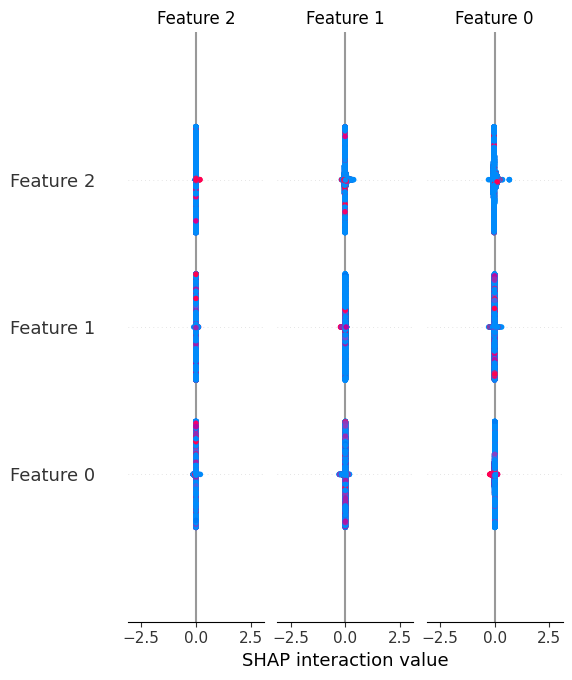

In [40]:
shap.summary_plot(shap_values, X_test_combined, plot_type="bar")

C:\Users\arina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing SHAP values for label 'center'...


Computing SHAP for center: 100%|██████████| 7376/7376 [00:16<00:00, 446.12it/s]


Completed SHAP values for center. Time elapsed: 16.54 seconds.
Computing SHAP values for label 'left'...


Computing SHAP for left: 100%|██████████| 7376/7376 [00:18<00:00, 392.98it/s]


Completed SHAP values for left. Time elapsed: 35.31 seconds.
Computing SHAP values for label 'right'...


Computing SHAP for right: 100%|██████████| 7376/7376 [00:18<00:00, 394.84it/s]


Completed SHAP values for right. Time elapsed: 53.99 seconds.
SHAP Summary for label 'center':


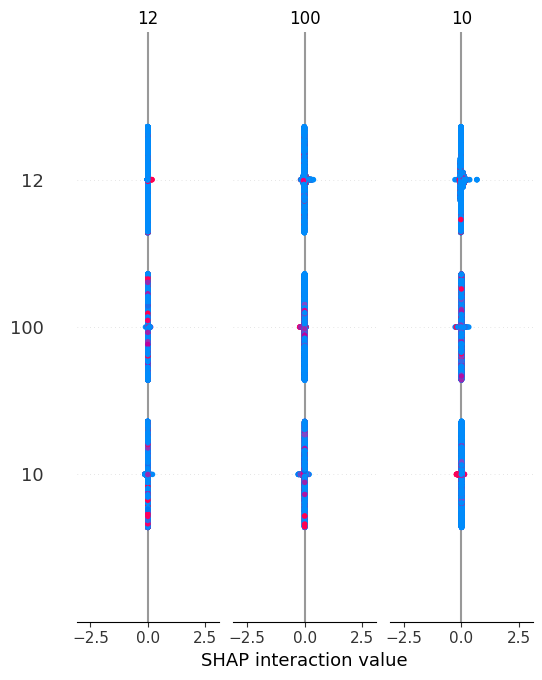

SHAP Summary for label 'left':


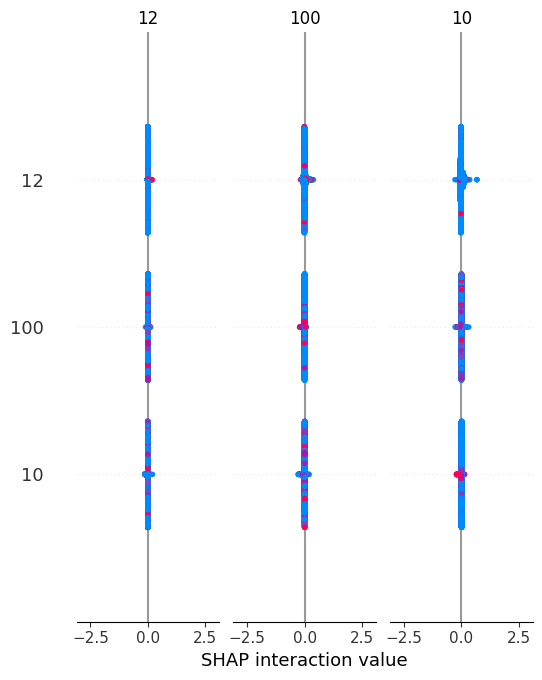

SHAP Summary for label 'right':


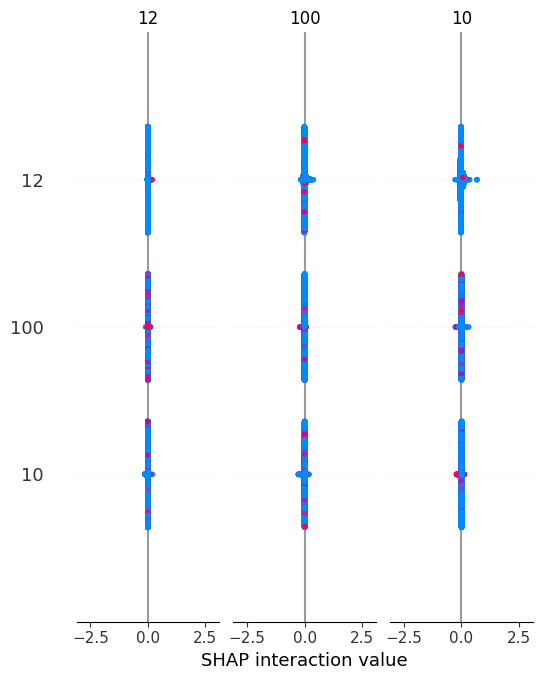

In [ ]:
import shap
from tqdm import tqdm
import time

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Define the list of labels
labels = ['center', 'left', 'right']

# Compute SHAP values for test data
shap_values = []

# Start the timer
start_time = time.time()

# Compute SHAP values for each class
for class_id, label in enumerate(labels):
    print(f"Computing SHAP values for label '{label}'...")

    # Add tqdm progress bar to monitor progress
    # The 'shap_values[class_id]' will be computed one by one in the loop
    tqdm_bar = tqdm(total=len(X_test_combined), desc=f"Computing SHAP for {label}", position=0)

    # Compute SHAP values with progress tracking
    shap_values_class = explainer.shap_values(X_test_combined)
    
    # Updating progress
    tqdm_bar.update(len(X_test_combined))
    
    shap_values.append(shap_values_class)
    tqdm_bar.close()

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Completed SHAP values for {label}. Time elapsed: {elapsed_time:.2f} seconds.")

# Plot SHAP summary for each class
for class_id, label in enumerate(labels):
    print(f"SHAP Summary for label '{label}':")
    shap.summary_plot(shap_values[class_id], X_test_combined, feature_names=feature_names)


In [13]:
import shap

# Assume you have already trained your model and transformed X_test_combined
# Assuming your model is CatBoost, XGBoost, or similar.

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for all classes
shap_values = explainer.shap_values(X_test_combined)

# Get the feature names from tf-idf
tfidf_feature_names = tfidf.get_feature_names_out()

# Combine with other numeric features
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Iterate over each class and extract the top 10 features
labels = ['center', 'left', 'right']  # Adjust as necessary

for class_id, label in enumerate(labels):
    print(f"Top 10 Features for {label}:")
    
    # Get the SHAP values for the current class
    shap_class_values = shap_values[class_id]
    
    # Calculate the mean absolute SHAP value for each feature
    feature_importance = np.abs(shap_class_values).mean(axis=0)
    
    # Create a DataFrame to view features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # Sort the features by importance (descending order)
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Print the top 10 features and their importance
    print(top_features)
    
    # Plot SHAP summary for the top 10 features only
    shap.summary_plot(shap_class_values, X_test_combined, feature_names=feature_names, max_display=10)
    print("\n")


Top 10 Features for center:


ValueError: All arrays must be of the same length

In [15]:
feature_importance = np.abs(shap_class_values).mean(axis=0)

In [16]:
feature_importance

array([0.00856614, 0.01067304, 0.01066378], dtype=float32)

In [17]:
shap_class_values = shap_values[class_id]

In [18]:
shap_class_values

array([[-3.9168838e-03, -1.3074533e-02,  6.7433985e-03],
       [ 2.3158424e-04,  2.5424731e-04, -6.8479814e-03],
       [ 4.8782435e-04, -1.0083960e-04, -2.7077901e-04],
       ...,
       [ 4.0658438e-03, -1.4730887e-02, -3.8832370e-03],
       [ 1.6170478e-01, -1.6582316e-01, -7.0256256e-03],
       [-1.7559111e-02,  3.8452665e-03,  1.2042919e-02]], dtype=float32)

In [20]:
import shap
import numpy as np
import pandas as pd

# Assuming you have already trained your model and transformed X_test_combined
# Assuming your model is CatBoost, XGBoost, or similar.

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for all classes
shap_values = explainer.shap_values(X_test_combined)

# Get feature names from TF-IDF
tfidf_feature_names = tfidf.get_feature_names_out()

# Numeric feature names (ensure this list is correct)
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Iterate over each class and extract the top 10 features
labels = ['center', 'left', 'right']  # Adjust as necessary

for class_id, label in enumerate(labels):
    print(f"Top 10 Features for {label}:")

    # Get the SHAP values for the current class
    shap_class_values = shap_values[class_id]

    # Check the number of features in shap_class_values
    if shap_class_values.shape[1] != len(feature_names):
        print("Warning: Shape mismatch between feature names and SHAP values")
        continue  # Skip if there is a mismatch

    # Calculate the mean absolute SHAP value for each feature across all samples
    feature_importance = np.abs(shap_class_values).mean(axis=0)
    
    # Create a DataFrame to view features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # Sort the features by importance (descending order)
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Print the top 10 features and their importance
    print(top_features)
    
    # Plot SHAP summary for the top 10 features only
    shap.summary_plot(shap_class_values, X_test_combined, feature_names=feature_names, max_display=10)
    print("\n")


Top 10 Features for center:
Top 10 Features for left:
Top 10 Features for right:
